In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [18]:
images = tf.data.Dataset.list_files("faces\\*.jpg")

In [19]:
def load_image(img):
    img_byte = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img_byte)
    return img

In [20]:
images = images.map(load_image)

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

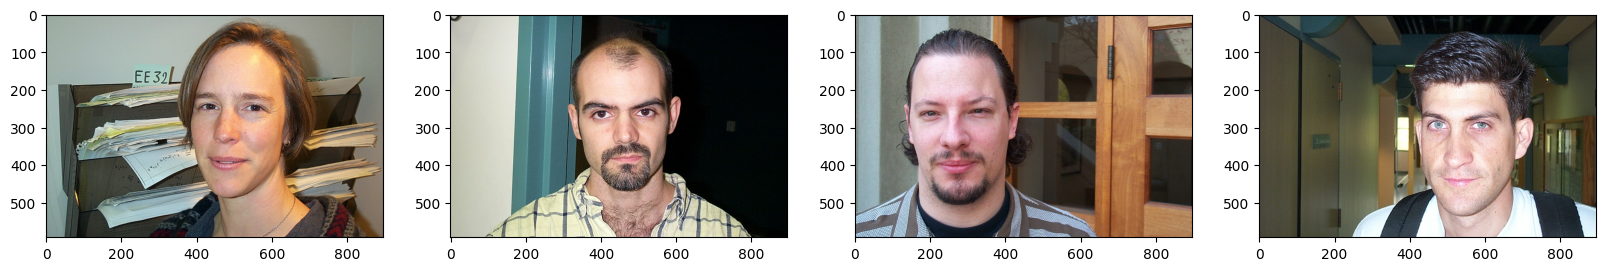

In [23]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [25]:
import shutil
import os
root_dir = "."
# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/test')
# os.makedirs(root_dir +'/val')

In [26]:
allFileNames = os.listdir("faces_size")
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


In [27]:
src = "faces_size"
train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
# for name in train_FileNames:
#     shutil.copy(name, "./train/")
# for name in test_FileNames:
#     shutil.copy(name, "./test/")
# for name in val_FileNames:
#     shutil.copy(name, "./val/")

Total images:  450
Training:  315
Validation:  67
Testing:  68


In [28]:
import cv2
import json

In [108]:
import albumentations as alb

In [93]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations',min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

In [123]:
for fol in ['train', 'test','val']:
    for image in os.listdir(fol):
        img = cv2.imread(os.path.join(fol,image))
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('faces-annotation',image.split(".")[0]+".json")
        with open(label_path,'r') as f:
            label = json.load(f)
        # print(image)
    
        coords[0] = label['shapes'][0]['points'][0][0]
        coords[1] = label['shapes'][0]['points'][0][1]
        coords[2] = label['shapes'][0]['points'][1][0]
        coords[3] = label['shapes'][0]['points'][1][1]
    
        coords = list(np.divide(coords,[600,600,600,600]))
    
        for x in range(5):
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
            cv2.imwrite(os.path.join('aug-data', fol,'images', f'{image.split(".")[0]}_{x}.jpg'), augmented['image'])
            annotation = {}
            annotation['image'] = image
    
            if os.path.exists(label_path):
                if len(augmented['bboxes']) == 0: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: 
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
            else: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 
    
            with open(os.path.join('aug-data',fol, 'labels', f'{image.split(".")[0]}_{x}.json'), 'w') as f:
                json.dump(annotation, f)


In [29]:
train_images = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\train\images\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\test\images\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\val\images\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [31]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [32]:
train_labels = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\train\labels\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\test\labels\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files(r'D:\Open-cv\face-reg\aug-data\val\labels\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


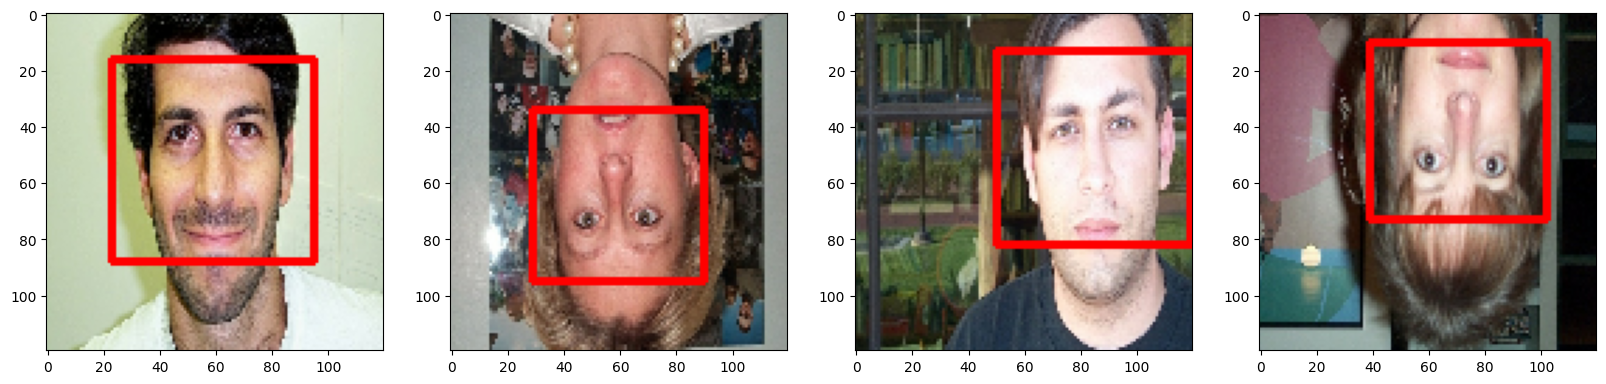

In [34]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [36]:
vgg = VGG16(include_top=False)

In [37]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [38]:
facetracker = build_model()

In [39]:
X, y = train.as_numpy_iterator().next()

In [40]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 377ms/step


In [41]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [42]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [43]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [44]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [45]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [46]:
model = FaceTracker(facetracker)

In [47]:
model.compile(opt, classloss, regressloss)

In [48]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
199/199 [==============================] - 211s 1s/step - total_loss: 0.3555 - class_loss: 0.0417 - regress_loss: 0.3346 - val_total_loss: 0.7729 - val_class_loss: 0.4142 - val_regress_loss: 0.5658
Epoch 2/10
199/199 [==============================] - 220s 1s/step - total_loss: 0.1233 - class_loss: 0.0233 - regress_loss: 0.1117 - val_total_loss: 0.0293 - val_class_loss: 4.6928e-04 - val_regress_loss: 0.0291
Epoch 3/10
199/199 [==============================] - 209s 1s/step - total_loss: 0.0950 - class_loss: 0.0135 - regress_loss: 0.0883 - val_total_loss: 0.0295 - val_class_loss: 0.0108 - val_regress_loss: 0.0241
Epoch 4/10
199/199 [==============================] - 202s 1s/step - total_loss: 0.0620 - class_loss: 0.0097 - regress_loss: 0.0572 - val_total_loss: 0.0379 - val_class_loss: 3.3627e-05 - val_regress_loss: 0.0379
Epoch 5/10
199/199 [==============================] - 210s 1s/step - total_loss: 0.0450 - class_loss: 0.0061 - regress_loss: 0.0420 - val_total_loss: 0.0183

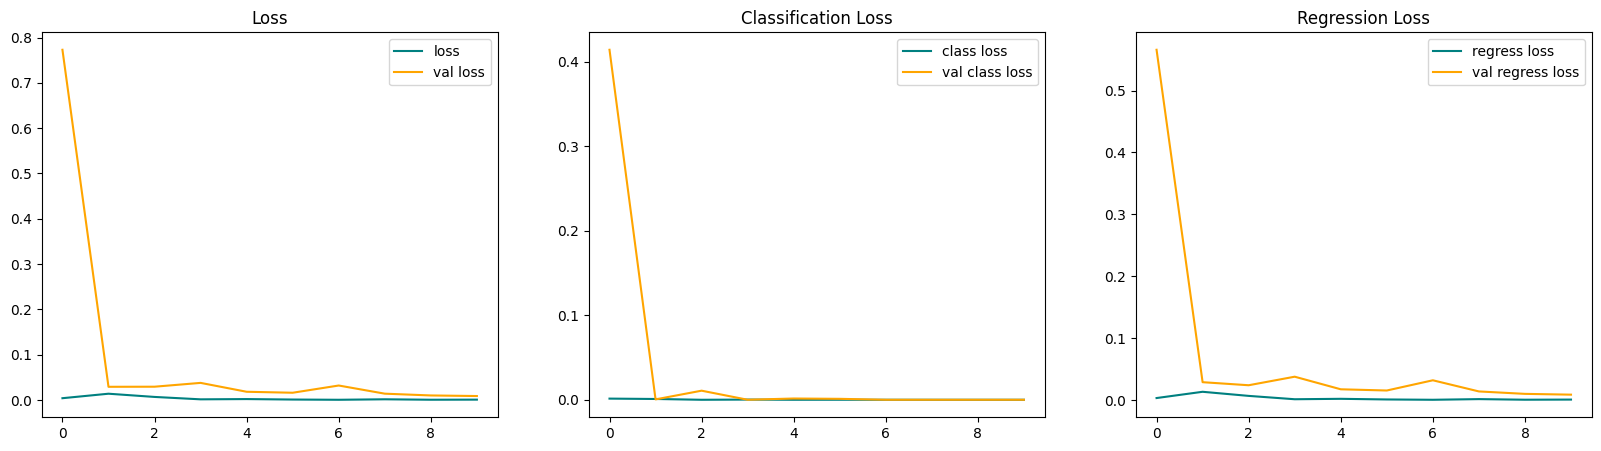

In [49]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [50]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 479ms/step


In [51]:
test = cv2.imread("test.jpg")
test = cv2.resize(test, (120,120))
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 477ms/step


In [160]:
sample_coords = yhat[1][0]
cv2.rectangle(test, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    


array([[[157, 222, 242],
        [171, 226, 239],
        [170, 217, 249],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [ 83,  97, 219]],

       [[157, 199, 219],
        [162, 208, 234],
        [135, 213, 226],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[153, 181, 202],
        [143, 193, 211],
        [136, 217, 222],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       ...,

       [[173, 205, 247],
        [198, 231, 253],
        [182, 222, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[192, 231, 254],
        [187, 225, 255],
        [188, 228, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[216, 241, 255],
        [208, 232, 254],
        [234, 251, 255],
        ...,
        [251, 255, 254],
        [255, 255, 255],
        [255, 255, 255]]

In [161]:
cv2.imwrite("test1.jpg",test)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


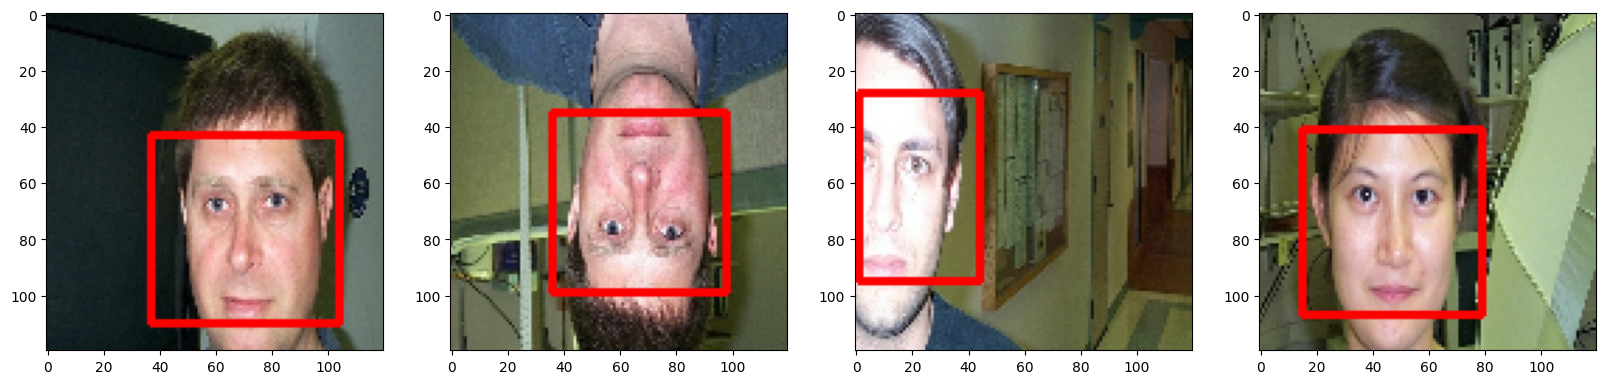

In [52]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [53]:
from tensorflow.keras.models import load_model

In [54]:
facetracker.save('facetracker.h5')


In [55]:
facetracker = load_model('facetracker.h5')

In [56]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 70ms/step
